---

# 📘 Notebook 01 — Dataset Exploration (AIDev Dataset)

This notebook performs an initial exploration of the **AIDev dataset** to understand its structure, schema, and basic properties.
The goal is to perform sanity checks, inspect the available fields, and compare the volume of **agent-authored** pull requests versus **human-authored** ones.

This notebook supports the overall **MSR 2026 Mining Challenge** study:

**Title:** *Machines Are Coding: But Are Humans Fixing? Understanding Review Dynamics in Agentic Pull Requests*
**Dataset:** *AIDev (Zenodo DOI: [10.5281/zenodo.16919272](https://doi.org/10.5281/zenodo.16919272))*

---

## 🎯 Objectives

* Load **agent PRs** and **human PRs** from separate files
* Combine them into a single PR dataset
* Inspect metadata, available fields, and distributions
* Perform sanity checks on the dataset
* Create a small **processed sample** for efficient later analysis (supporting RQ1, RQ2, RQ3)

---

## 📦 Files used in this notebook

* `pull_request.parquet`
* `human_pull_request.parquet`
* `pr_commit_details.parquet`
* `pr_comments.parquet` (optional for quick checks)
* `repository.parquet` (for repo metadata)

---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


DATA_DIR = "../data/raw/16919272/"
PROCESSED_DIR = "../data/processed/"

os.makedirs(PROCESSED_DIR, exist_ok=True)

print("Data directory:", DATA_DIR)
print("Files:", os.listdir(DATA_DIR))

Data directory: ../data/raw/16919272/
Files: ['pr_timeline.parquet', 'pr_cumulative.png', 'pull_request.parquet', 'pr_task_type.parquet', 'all_repository.parquet', 'pr_review_comments.parquet', 'pr_review_comments_v2.parquet', 'all_pull_request.parquet', 'pr_commits.parquet', 'human_pr_task_type.parquet', 'human_pull_request.parquet', 'data_table.md', 'user.parquet', 'README.md', 'pr_comments.parquet', 'related_issue.parquet', 'schema.png', 'repository.parquet', 'pr_reviews.parquet', 'issue.parquet', 'pr_commit_details.parquet', 'all_user.parquet', 'README.pdf', 'aidev_logo.png']


In [2]:
def load_parquet(name):
    """
    Convenience loader that prints what it loads.
    Expects <name>.parquet in DATA_DIR.
    """
    path = os.path.join(DATA_DIR, f"{name}.parquet")
    if os.path.exists(path):
        df = pd.read_parquet(path)
        print(f"{name}.parquet loaded — shape: {df.shape}")
        return df
    else:
        print(f"WARNING: {name}.parquet not found in {DATA_DIR}")
        return None

In [3]:
all_pull_request = load_parquet("all_pull_request")  # AGENTIC ONLY (Full AIDev)
all_repository   = load_parquet("all_repository")
all_user         = load_parquet("all_user")

if all_pull_request is not None:
    print("\nall_pull_request columns:", list(all_pull_request.columns))

all_pull_request.parquet loaded — shape: (932791, 14)
all_repository.parquet loaded — shape: (116211, 7)
all_user.parquet loaded — shape: (72189, 5)

all_pull_request columns: ['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url']


In [4]:
pull_request          = load_parquet("pull_request")          # agentic PRs (subset = AIDev-pop)
repository            = load_parquet("repository")
pr_timeline           = load_parquet("pr_timeline")
pr_comments           = load_parquet("pr_comments")
pr_reviews            = load_parquet("pr_reviews")
pr_review_comments_v2 = load_parquet("pr_review_comments_v2")
pr_commits            = load_parquet("pr_commits")
pr_commit_details     = load_parquet("pr_commit_details")
pr_task_type          = load_parquet("pr_task_type")
issue                 = load_parquet("issue")
related_issue         = load_parquet("related_issue")
user_pop              = load_parquet("user")

pull_request.parquet loaded — shape: (33596, 14)
repository.parquet loaded — shape: (2807, 7)
pr_timeline.parquet loaded — shape: (325500, 8)
pr_comments.parquet loaded — shape: (39122, 7)
pr_reviews.parquet loaded — shape: (28875, 7)
pr_review_comments_v2.parquet loaded — shape: (26868, 15)
pr_commits.parquet loaded — shape: (88576, 5)
pr_commit_details.parquet loaded — shape: (711923, 14)
pr_task_type.parquet loaded — shape: (33596, 6)
issue.parquet loaded — shape: (4614, 9)
related_issue.parquet loaded — shape: (4923, 3)
user.parquet loaded — shape: (1796, 5)


In [5]:
human_pull_request = load_parquet("human_pull_request")
human_pr_task_type = load_parquet("human_pr_task_type")

if human_pull_request is not None:
    print("\nhuman_pull_request columns:", list(human_pull_request.columns))

human_pull_request.parquet loaded — shape: (6618, 13)
human_pr_task_type.parquet loaded — shape: (6618, 6)

human_pull_request columns: ['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'html_url', 'body', 'agent']


In [6]:
summary_counts = {}

if all_pull_request is not None:
    summary_counts["agent_full_total_prs"] = len(all_pull_request)

if pull_request is not None:
    summary_counts["agent_pop_total_prs"] = len(pull_request)

if human_pull_request is not None:
    summary_counts["human_pop_total_prs"] = len(human_pull_request)

pd.DataFrame([summary_counts])

,agent_full_total_prs,agent_pop_total_prs,human_pop_total_prs
0,932791,33596,6618


In [7]:
# Make defensive copies
agent_pop = pull_request.copy()
agent_pop["author_type"] = "agent"

human_pop = human_pull_request.copy()
human_pop["author_type"] = "human"

# Align columns using intersection, EXCLUDING 'author_type'
common_cols = sorted(
    (set(agent_pop.columns) & set(human_pop.columns)) - {"author_type"}
)
print("Number of common columns:", len(common_cols))

combined_pr = pd.concat(
    [
        agent_pop[common_cols + ["author_type"]],
        human_pop[common_cols + ["author_type"]],
    ],
    ignore_index=True
)

# Now this is a normal Series
combined_pr["author_type"].value_counts()

Number of common columns: 13


author_type
agent    33596
human     6618
Name: count, dtype: int64

In [8]:
combined_pr.info()

combined_pr.isna().mean().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40214 entries, 0 to 40213
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   agent        40214 non-null  object
 1   body         38859 non-null  object
 2   closed_at    37433 non-null  object
 3   created_at   40214 non-null  object
 4   html_url     40214 non-null  object
 5   id           40214 non-null  int64 
 6   merged_at    29095 non-null  object
 7   number       40214 non-null  int64 
 8   repo_url     40214 non-null  object
 9   state        40214 non-null  object
 10  title        40214 non-null  object
 11  user         40214 non-null  object
 12  user_id      40214 non-null  int64 
 13  author_type  40214 non-null  object
dtypes: int64(3), object(11)
memory usage: 4.3+ MB


merged_at      0.276496
closed_at      0.069155
body           0.033695
agent          0.000000
created_at     0.000000
html_url       0.000000
id             0.000000
number         0.000000
repo_url       0.000000
state          0.000000
title          0.000000
user           0.000000
user_id        0.000000
author_type    0.000000
dtype: float64

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


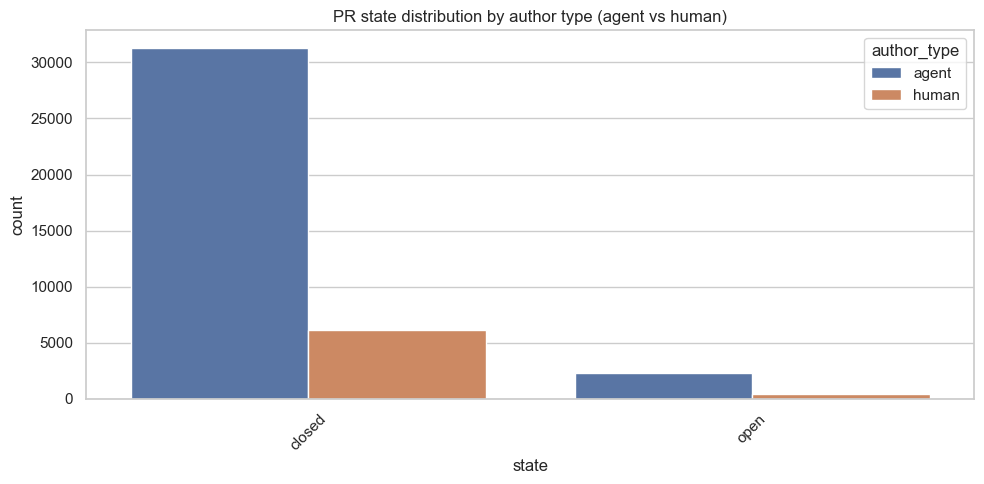

In [9]:
if "state" in combined_pr.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(
        data=combined_pr,
        x="state",
        hue="author_type",
        order=combined_pr["state"].value_counts().index
    )
    plt.title("PR state distribution by author type (agent vs human)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'state' not found in combined_pr")

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

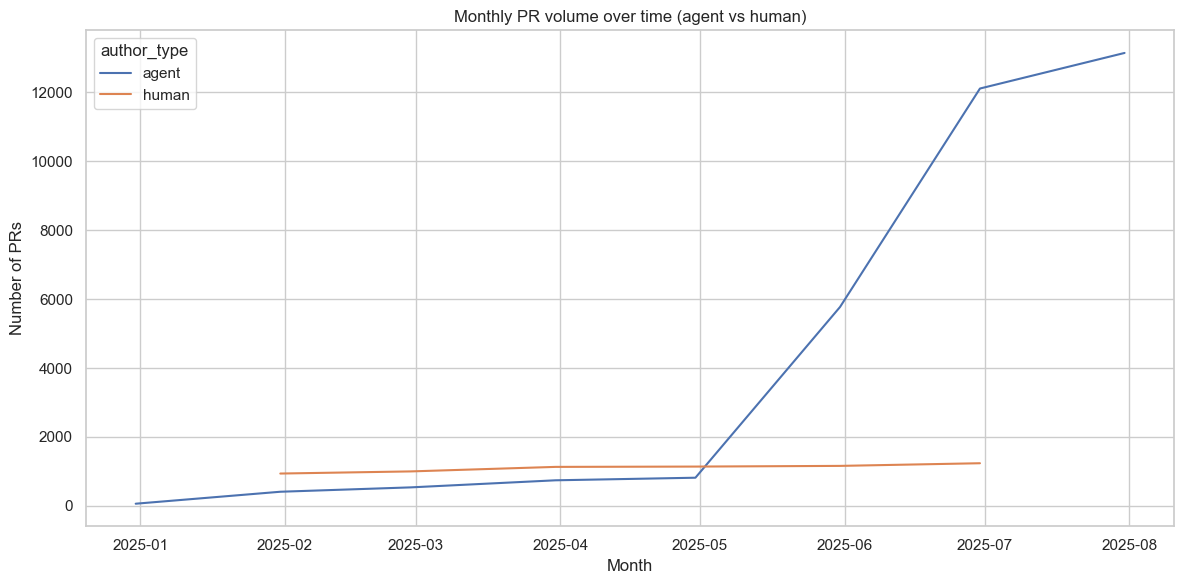

In [10]:
if "created_at" in combined_pr.columns:
    combined_pr["created_at"] = pd.to_datetime(combined_pr["created_at"], errors="coerce")

    monthly_volume = (
        combined_pr
        .set_index("created_at")
        .groupby("author_type")
        .resample("M")
        .size()
        .reset_index(name="count")
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=monthly_volume,
        x="created_at",
        y="count",
        hue="author_type"
    )
    plt.title("Monthly PR volume over time (agent vs human)")
    plt.ylabel("Number of PRs")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'created_at' not available for timeline plotting.")

In [11]:
def coverage(df, pr_col, agent_ids, human_ids, label):
    if df is None or pr_col not in df.columns:
        print(f"{label}: table missing or column '{pr_col}' not present.")
        return
    print(f"\n{label}:")
    cov_agent = df[pr_col].isin(agent_ids).mean()
    cov_human = df[pr_col].isin(human_ids).mean()
    print(f"  Coverage for agent PRs: {cov_agent:.3f}")
    print(f"  Coverage for human PRs: {cov_human:.3f}")

agent_ids = agent_pop["id"]
human_ids = human_pop["id"]

coverage(pr_commit_details, "pr_id", agent_ids, human_ids, "Commit details (pr_commit_details)")
coverage(pr_review_comments_v2, "pr_id", agent_ids, human_ids, "Review comments (pr_review_comments_v2)")
coverage(pr_comments, "pr_id", agent_ids, human_ids, "Issue-style PR comments (pr_comments)")
coverage(pr_timeline, "pr_id", agent_ids, human_ids, "Timeline events (pr_timeline)")


Commit details (pr_commit_details):
  Coverage for agent PRs: 1.000
  Coverage for human PRs: 0.000
Review comments (pr_review_comments_v2): table missing or column 'pr_id' not present.

Issue-style PR comments (pr_comments):
  Coverage for agent PRs: 1.000
  Coverage for human PRs: 0.000

Timeline events (pr_timeline):
  Coverage for agent PRs: 1.000
  Coverage for human PRs: 0.000


In [12]:
if pr_commit_details is not None:
    # Basic churn aggregation
    churn_agg = pr_commit_details.groupby("pr_id").agg(
        total_additions=("additions", "sum"),
        total_deletions=("deletions", "sum"),
        total_changed_files=("filename", "nunique"),
    ).reset_index()

    # Very simple file-type tagging
    pr_commit_details["is_test_file"] = pr_commit_details["filename"].str.contains(
        "test", case=False, na=False
    )
    pr_commit_details["is_config_file"] = pr_commit_details["filename"].str.contains(
        r"(yaml|yml|json|toml|ini|config)", case=False, na=False
    )

    file_type_agg = pr_commit_details.groupby("pr_id").agg(
        n_test_files=("is_test_file", "sum"),
        n_config_files=("is_config_file", "sum"),
    ).reset_index()

    churn_features = churn_agg.merge(file_type_agg, on="pr_id", how="left")
    print("Churn feature shape:", churn_features.shape)
else:
    churn_features = None
    print("No pr_commit_details loaded; churn_features is None.")

/var/folders/jq/3wy0vbqs6tsct67mt8g3xkb00000gn/T/ipykernel_32916/1065000088.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pr_commit_details["is_config_file"] = pr_commit_details["filename"].str.contains(


Churn feature shape: (33580, 6)


In [13]:
if churn_features is not None:
    agent_features = agent_pop.merge(
        churn_features,
        left_on="id",
        right_on="pr_id",
        how="left"
    )
    agent_features.drop(columns=["pr_id"], inplace=True, errors="ignore")
else:
    agent_features = agent_pop.copy()

agent_features.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,author_type,total_additions,total_deletions,total_changed_files,n_test_files,n_config_files
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911,agent,394.0,2.0,3.0,1.0,0.0
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2,agent,38.0,38.0,11.0,1.0,0.0
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30,agent,298.0,109.0,5.0,0.0,0.0
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,agent,288.0,12.0,15.0,0.0,1.0
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625,agent,53.0,168.0,21.0,3.0,0.0


In [14]:
churn_cols = ["total_additions", "total_deletions", "total_changed_files"]

existing_churn_cols = [c for c in churn_cols if c in agent_features.columns]

if existing_churn_cols:
    agent_features[existing_churn_cols].describe(percentiles=[0.5, 0.9, 0.99])
else:
    print("No churn columns present in agent_features yet.")

In [15]:
# Main unified PR table with author_type (AIDev-pop + Human-PR)
combined_path = os.path.join(PROCESSED_DIR, "combined_pr_pop.parquet")
combined_pr.to_parquet(combined_path)
print("Saved:", combined_path)

# Agent-only feature table for RQ2
agent_features_path = os.path.join(PROCESSED_DIR, "agent_features_pop.parquet")
agent_features.to_parquet(agent_features_path)
print("Saved:", agent_features_path)

# Optional: churn-only table
if churn_features is not None:
    churn_path = os.path.join(PROCESSED_DIR, "churn_features.parquet")
    churn_features.to_parquet(churn_path)
    print("Saved:", churn_path)

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Saved: ../data/processed/combined_pr_pop.parquet
Saved: ../data/processed/agent_features_pop.parquet
Saved: ../data/processed/churn_features.parquet


In [17]:
import os
import pandas as pd

DATA_DIR = "../data/raw/16919272/"
PROCESSED_DIR = "../data/processed/"
os.makedirs(PROCESSED_DIR, exist_ok=True)

pull_request = pd.read_parquet(os.path.join(DATA_DIR, "pull_request.parquet"))
human_pull_request = pd.read_parquet(os.path.join(DATA_DIR, "human_pull_request.parquet"))

print("Agent PR columns:", sorted(pull_request.columns))
print("Human PR columns:", sorted(human_pull_request.columns))

agent_df = pull_request.copy()
agent_df["author_type"] = "agent"

human_df = human_pull_request.copy()
human_df["author_type"] = "human"

cols = [
    "author_type",
    "id",         # PR id
    "number",     # PR number in repo
    "html_url",   # PR URL (this alone is enough for CI)
]

ci_targets = pd.concat(
    [agent_df[cols], human_df[cols]],
    ignore_index=True
).rename(columns={
    "id": "pr_id",
    "number": "pr_number",
    "html_url": "pr_html_url",
})

print(ci_targets.head())
print("Total rows:", len(ci_targets))

out_path = os.path.join(PROCESSED_DIR, "ci_targets_for_prof_taher.csv")
ci_targets.to_csv(out_path, index=False)
print("Saved CSV to:", out_path)

Agent PR columns: ['agent', 'body', 'closed_at', 'created_at', 'html_url', 'id', 'merged_at', 'number', 'repo_id', 'repo_url', 'state', 'title', 'user', 'user_id']
Human PR columns: ['agent', 'body', 'closed_at', 'created_at', 'html_url', 'id', 'merged_at', 'number', 'repo_url', 'state', 'title', 'user', 'user_id']
  author_type       pr_id  pr_number  \
0       agent  3264933329       2911   
1       agent  3265118634          2   
2       agent  3265640341         30   
3       agent  3265709660        205   
4       agent  3265782173      17625   

                                         pr_html_url  
0    https://github.com/milvus-io/pymilvus/pull/2911  
1      https://github.com/classmethod/tsumiki/pull/2  
2       https://github.com/steipete/Peekaboo/pull/30  
3  https://github.com/sugyan/claude-code-webui/pu...  
4     https://github.com/paradigmxyz/reth/pull/17625  
Total rows: 40214
Saved CSV to: ../data/processed/ci_targets_for_prof_taher.csv
